# Imports

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

import albumentations as album
import tensorflow as tf

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
print("Finished")

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
Finished


# Dirs

In [2]:
# FOR COLAB

# %env KAGGLE_USERNAME=pgrynfelder
# %env KAGGLE_KEY=db39d1a3db70f8135b05b032937ce861

# !kaggle datasets download -d balraj98/massachusetts-roads-dataset --force
# !unzip -q massachusetts-roads-dataset.zip

# print("Finished")

In [3]:


# DATA_DIR = '../input/massachusetts-roads-dataset/tiff/'
DATA_DIR = "tiff"
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [4]:
# class_dict = pd.read_csv("../input/massachusetts-roads-dataset/label_class_dict.csv")
class_dict = pd.read_csv("label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


#### Shortlist specific classes to segment

In [5]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'road']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### Import helper functions

In [6]:
from utils import *

# Dataset

In [7]:
class RoadsDataset(tf.keras.utils.Sequence):

    """Massachusetts Roads Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            batch_size,
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.batch_size = batch_size
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __len__(self):
        return len(self.image_paths) // self.batch_size
    
    
    def __getsingle(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __getitem__(self, i):
        indices = range(self.batch_size*i, min(len(self.image_paths), self.batch_size*(i+1)))
        X, Y = [], []
        for j in indices:
            x, y = self.__getsingle(j)
            X.append(x)
            Y.append(y)
        return np.array(X), np.array(Y)

#### Show image

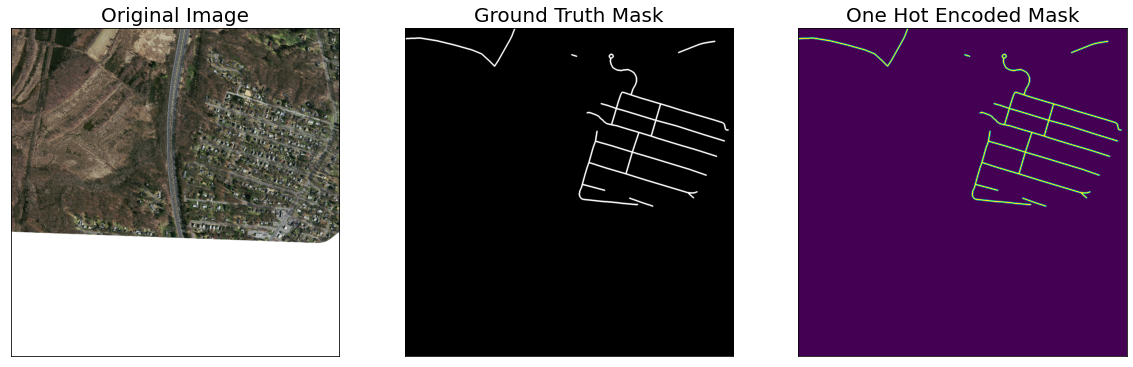

In [8]:
dataset = RoadsDataset(32, x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)


images, masks = dataset[2]

image, mask = images[0], masks[0]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Augmentations

In [9]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    # _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

### Show augumented

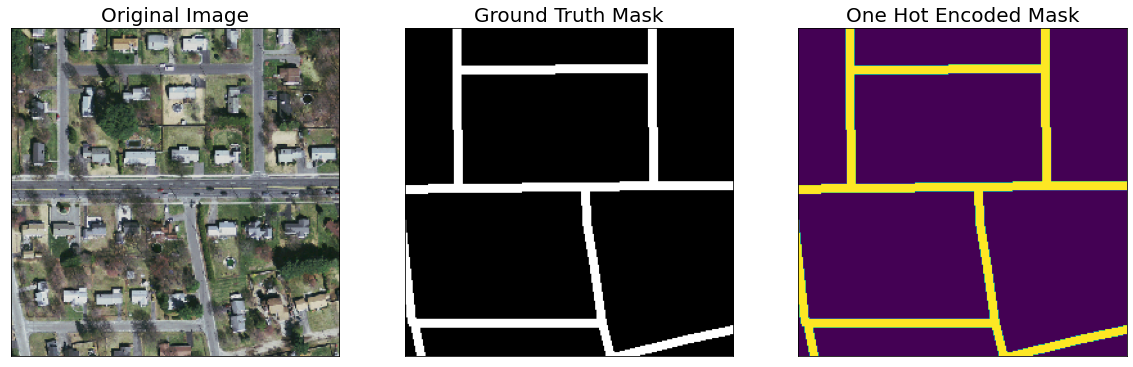

In [10]:
augmented_dataset = RoadsDataset(
    32,
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
images, masks = augmented_dataset[5]
image, mask = images[0], masks[0]
visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Train

In [11]:
# Get train and val dataset instances
train_dataset = RoadsDataset(
    32,
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    1,
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(),
    class_rgb_values=select_class_rgb_values,
)

In [22]:
BACKBONE = "resnet50"
preprocess_input = sm.get_preprocessing(BACKBONE)
train_dataset = preprocess_input(train_dataset)
valid_dataset = preprocess_input(valid_dataset)

In [13]:
model = sm.Unet(BACKBONE, classes=2, input_shape=(256,256,3))

!mkdir models
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/epoch{epoch:02d}-iou{val_iou_score:.4f}.h5"
)



mkdir: cannot create directory ‘models’: File exists


In [14]:
model.compile(
    "Adam", loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score]
)  # bce jaccard == IOU
# maybe dice loss here?


In [15]:
# model.fit(train_dataset, epochs=10, callbacks=[model_checkpoint_callback], validation_data=valid_dataset)

In [16]:
model.load_weights("models/iou/epoch11-iou0.7076.h5")

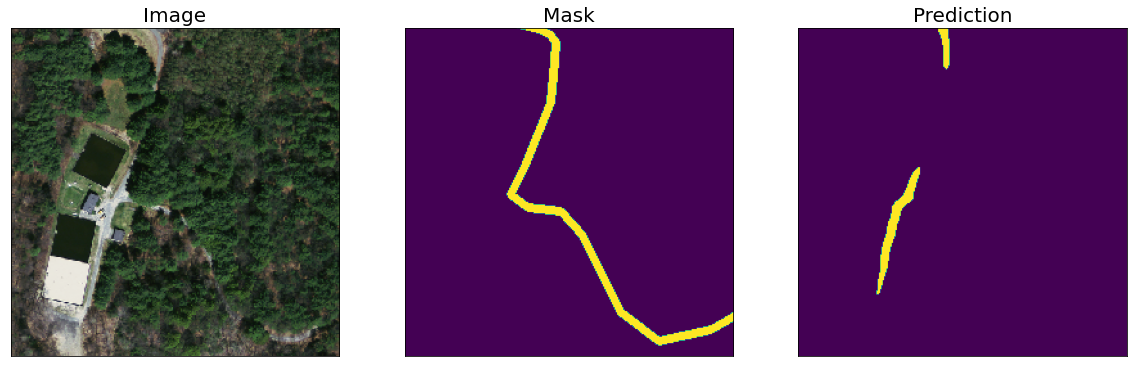

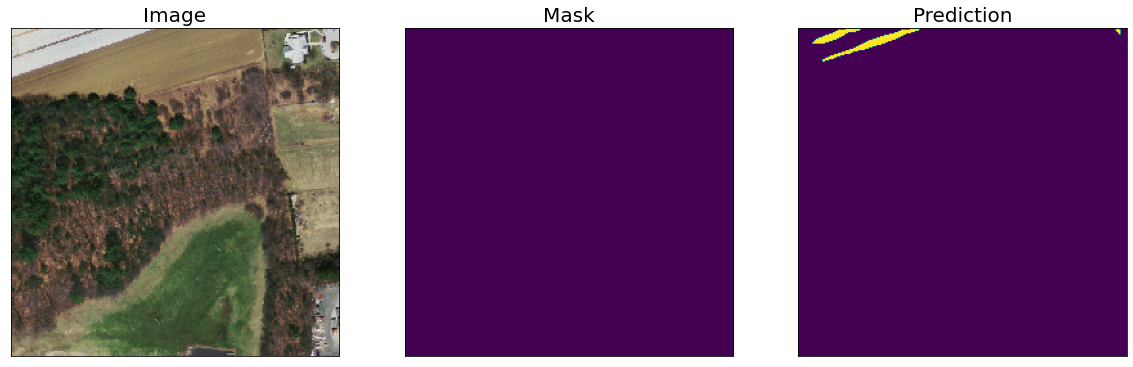

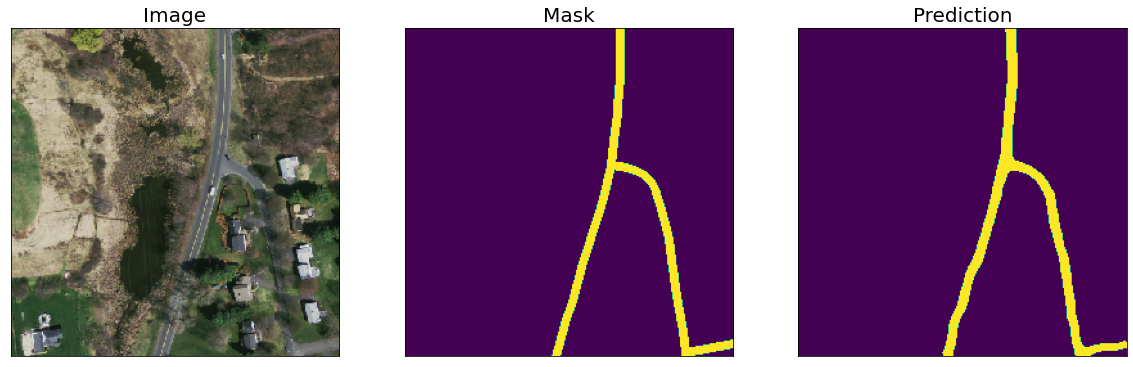

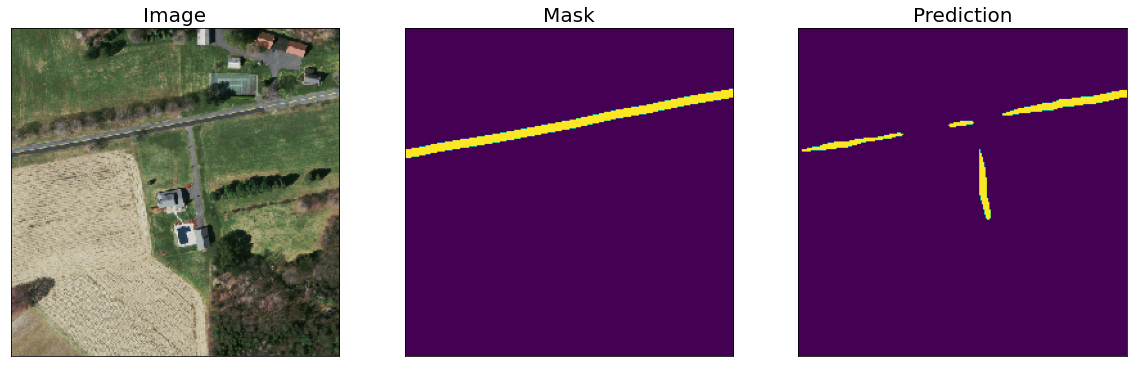

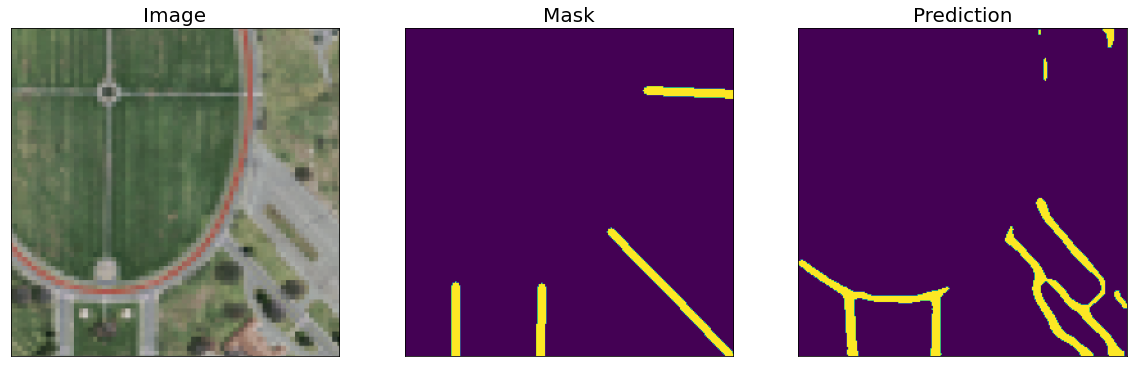

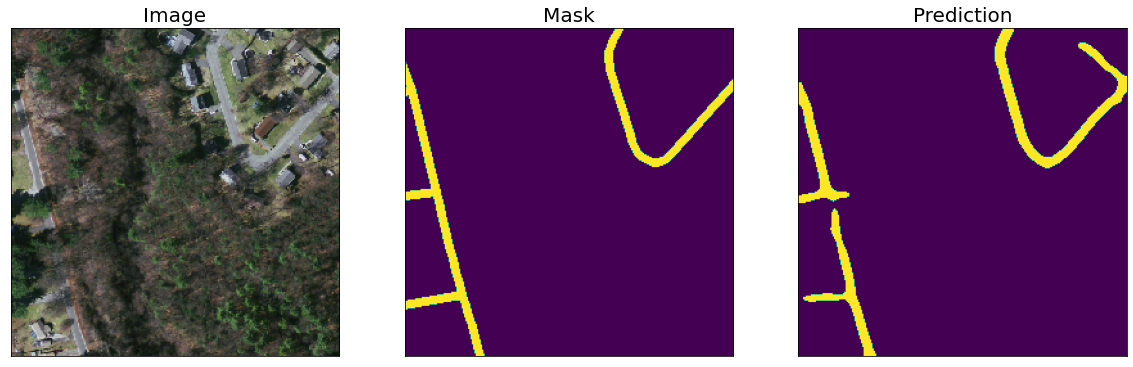

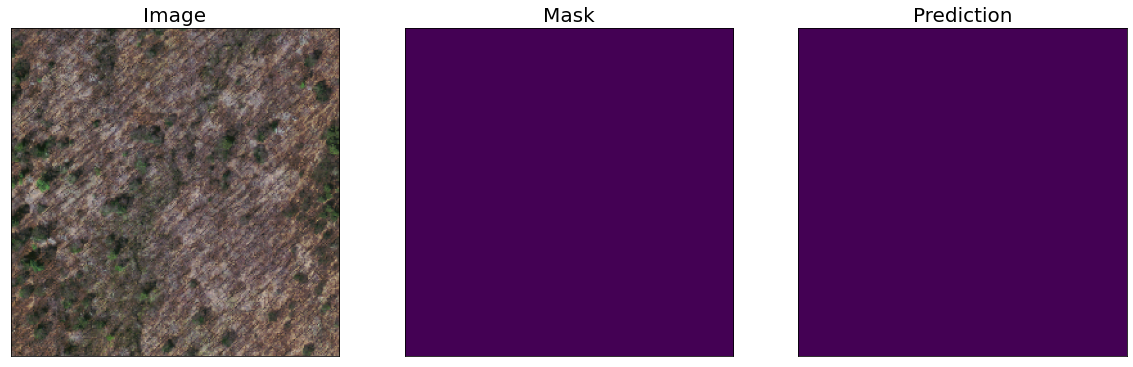

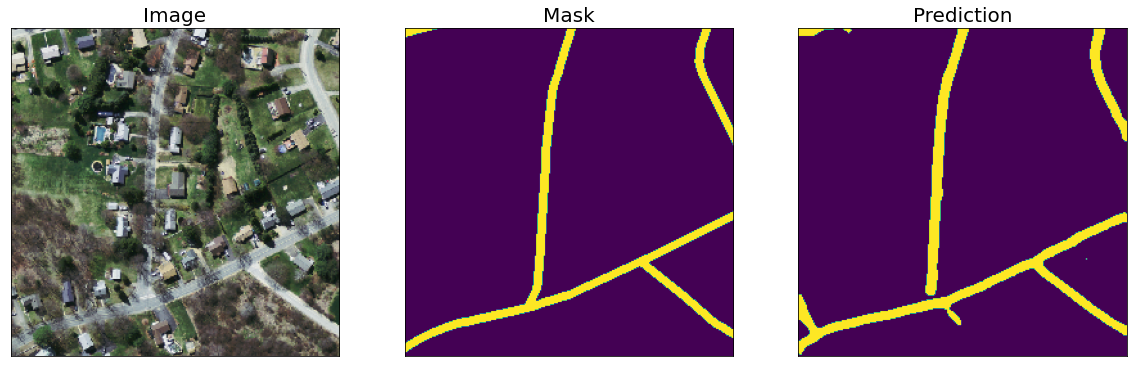

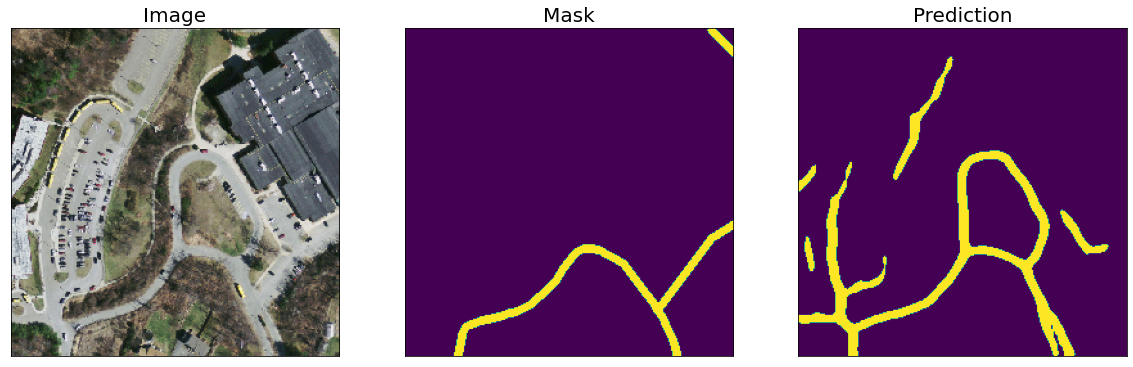

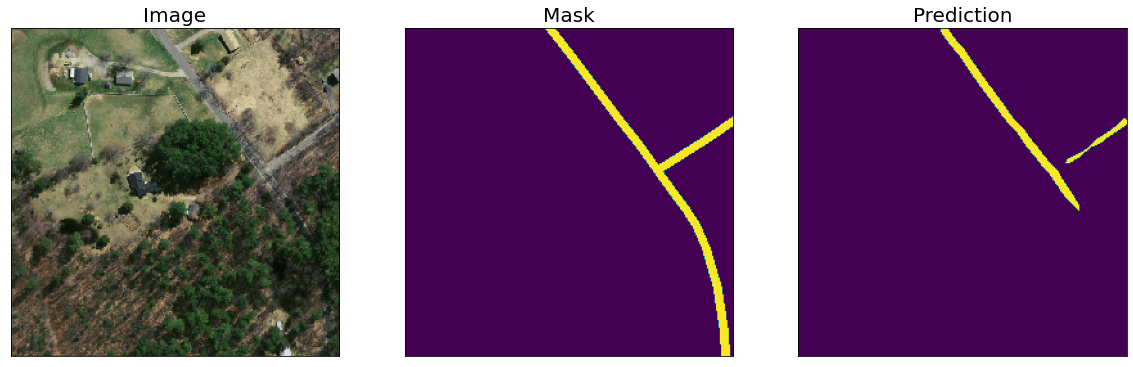

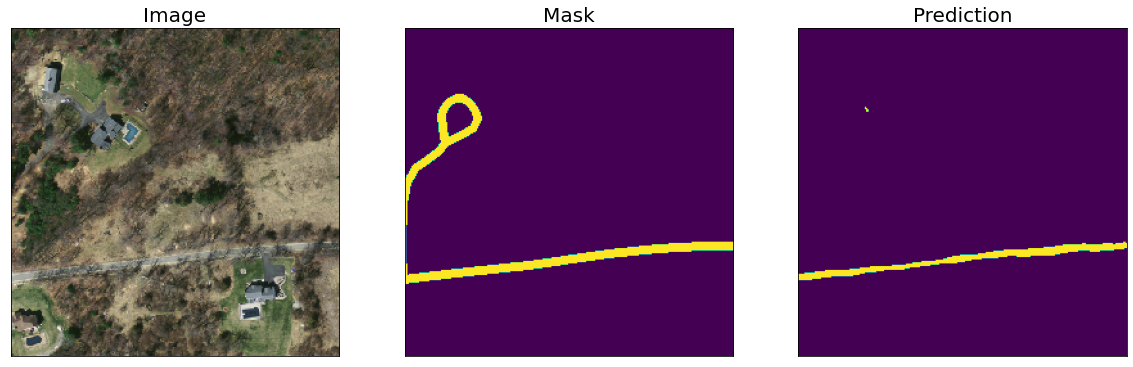

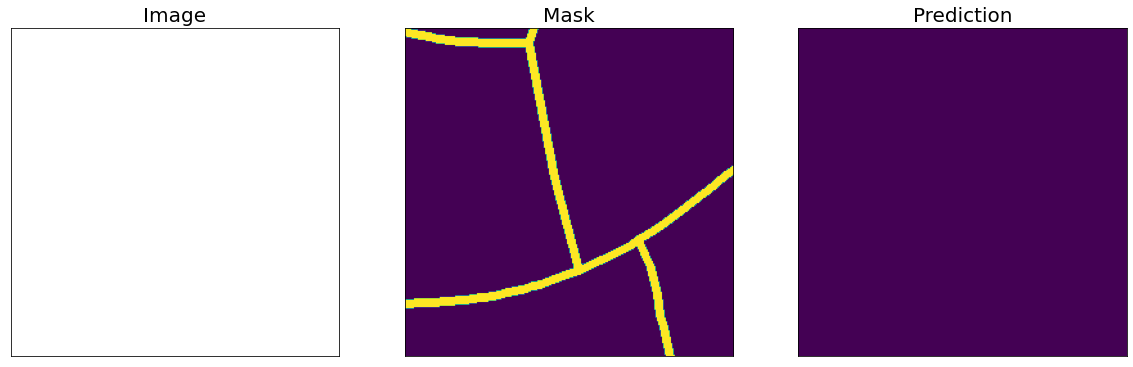

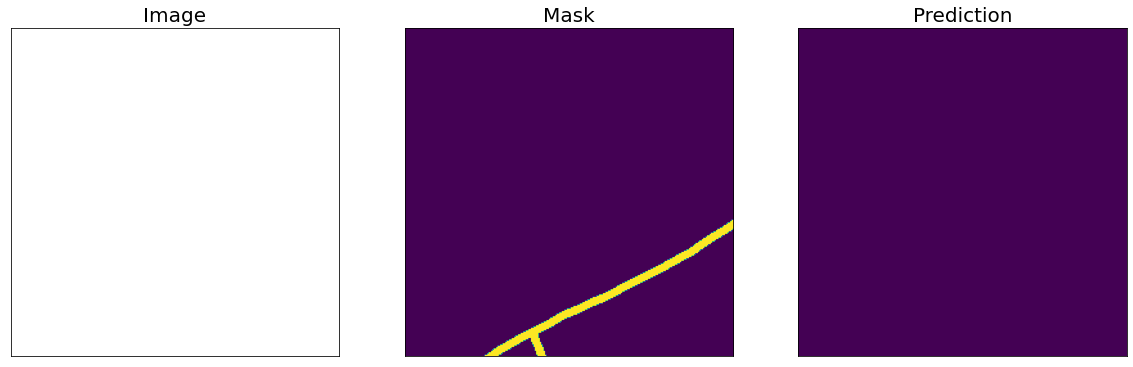

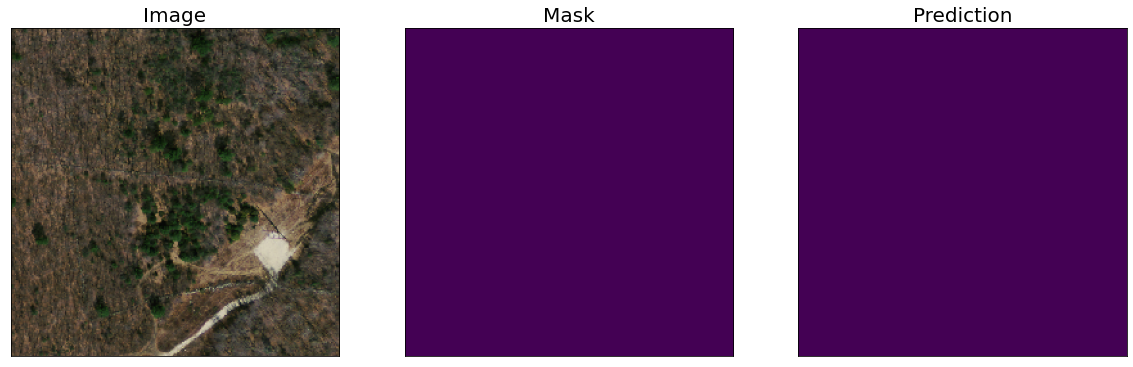

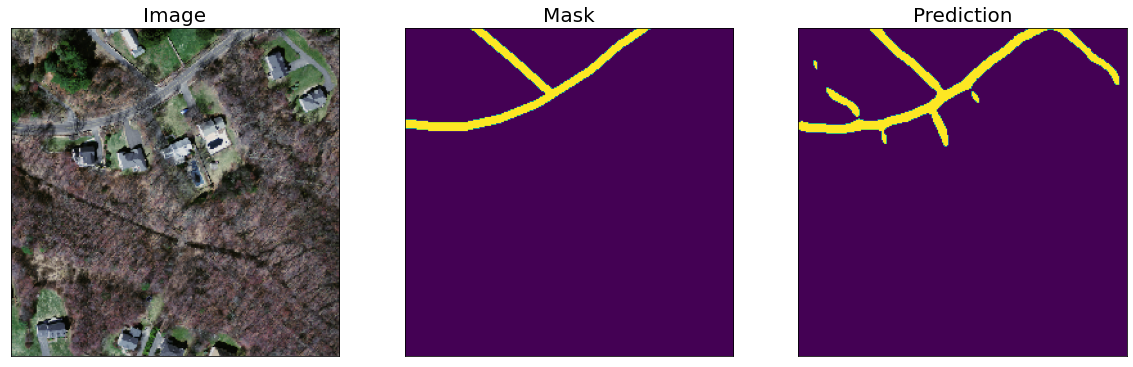

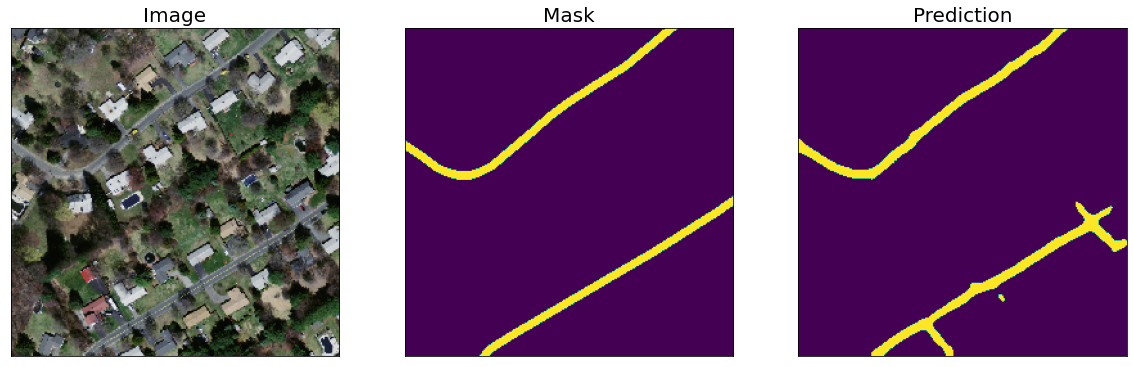

In [32]:
for i in range(16):
    idx = random.randint(0,15)
    images, masks = train_dataset[i]
    image, mask = images[idx], masks[idx]
    prediction = model.predict(images)[idx]
    visualize(image=image, mask=reverse_one_hot(mask), prediction=reverse_one_hot(prediction))
